In [92]:
RANDOM_STATE=42

#Training params
BATCH_SIZE = 64
EPOCHS = 15
NUM_CLASSES = 120
INPUT_SHAPE = (224, 224, 3)
IMAGE_SIZE = (224, 224)

USE_DROPOUT = True
DROPOUT_RATE = 0.5

DATA_PATH = '../data/'

In [26]:
DATA_PATH + 'train'

'../data/train'

In [93]:
import keras
import pickle
import numpy as np
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.style.use('classic')
%matplotlib inline

#Models
from keras import Model
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.layers.core import Dense
from keras.applications import ResNet50, VGG16, InceptionV3

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.applications import inception_v3

#Sklearn
from sklearn import metrics

In [94]:
def get_test_train_datagenerators(
    preprocessing_function, validation_split=None, target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, seed=RANDOM_STATE):
    
    generators = []
    
    train_datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=preprocessing_function,
            validation_split=validation_split
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )
    
    if validation_split:
        #Generator for train data
        train_generator = train_datagen.flow_from_directory(
                DATA_PATH + 'train',  # this is the target directory
                target_size=target_size,
                batch_size=batch_size,
                shuffle=True,
                class_mode='categorical',
                subset='training',
                seed=seed
        ) 

        validation_generator = train_datagen.flow_from_directory(
                DATA_PATH + 'train',  # this is the target directory
                target_size=target_size,
                batch_size=batch_size,
                shuffle=True,
                class_mode='categorical',
                subset='validation',
                seed=seed
        ) 
        
        generators.append(train_generator)
        generators.append(validation_generator)
    
    else:
        train_generator = train_datagen.flow_from_directory(
                DATA_PATH + 'train',  # this is the target directory
                target_size=target_size,
                batch_size=batch_size,
                shuffle=True,
                class_mode='categorical'
        )
        generators.append(train_generator)

    #Generator for test data
    test_generator = test_datagen.flow_from_directory(
            DATA_PATH + 'test',
            target_size=target_size,
            batch_size=batch_size,
            shuffle=True,
            class_mode='categorical',
            seed=seed
    )
    generators.append(test_generator)
    
    return generators

In [95]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [96]:
def get_callbacks(model_name):
    save_callback = keras.callbacks.ModelCheckpoint(
      DATA_PATH + 'models/%s.{epoch:02d}-{val_acc:.2f}.hdf5' %model_name, monitor='val_acc', verbose=0, 
      save_best_only=True, save_weights_only=False, mode='auto', period=2
    )
    time_callback = TimeHistory()
    ealy_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=2)
    
    return [save_callback, time_callback, ealy_stopping_callback]


def compile_model(base_model, learning_rate=5e-4, use_dropout=USE_DROPOUT):
    for layer in base_model.layers:
        layer.trainable = False
    
    #Add our own layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    if use_dropout:
        x = Dropout(DROPOUT_RATE)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    #Compile model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, epsilon=None),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def train_model(model, generator, validation_generator):
    history = model.fit_generator(generator=generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    #steps_per_epoch= len(generator.classes) // BATCH_SIZE,
                    #validation_steps= len(generator.classes) // BATCH_SIZE,
                    #workers=4,
                    #callbacks = callbacks
                    #use_multiprocessing=True
    )
    
    return model, history

In [97]:
def plot_model_history_performance(history, title='Accuracy and Validation Accuracy'):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    t = np.linspace(1, len(acc), len(acc)).flatten()
    plt.plot(t, acc, 'navy', label='accuracy')
    plt.plot(t, val_acc, 'lightblue', label='validation accuracy')

    plt.grid(True)
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend(loc=4)
    plt.show();

In [98]:
def get_mean_inference_time(model, generator, n_inferences=10):
    start = time.time()
    
    model.predict_generator(generator, n_inferences)
    
    total_inference_time = time.time() - start
    mean_inference_time = total_inference_time / (n_inferences * BATCH_SIZE)
    
    return mean_inference_time

In [99]:
def add_model_stats(model_stats, model_name, history, time_callback, test_accuracy, inference_time):
    model_stats['models'].append(model_name)
    
    #Accuracy & validation accuracy
    acc = history.history['acc'][-1]
    model_stats['accuracy'].append(acc * 100)
    model_stats['test_accuracy'].append(test_accuracy * 100)
    
    #Mean epoch training time
    epoch_training_time = np.mean(time_callback.times[1:])
    model_stats['epoch_training_time'].append(epoch_training_time)
    
    #Inference time
    model_stats['inference_time_10000pic'].append(inference_time * 10000)
    
    #Print results
    print('Accuracy: %0.1f%% / Test accuracy: %0.1f%%' %(acc*100, test_accuracy*100))
    print('Mean epoch training time: %is' %int(epoch_training_time))
    print('Mean 10000 inference time: %0.1fs' %(inference_time*10000))
    
    return model_stats

In [100]:
def plot_model_stats(stats, figsize=(6, 6)):
    blues_cm = cm.Blues
    width = 0.2
    ind = np.arange(3)
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.barh(ind + width, stats['accuracy'], width, color=blues_cm(0.9), label="accuracy", edgecolor='white')
    ax.barh(ind + 2 * width, stats['test_accuracy'], width, color=blues_cm(0.7),  label="test accuracy", edgecolor='white')
    ax.barh(ind + 3 * width, stats['inference_time_10000pic'], width, color=blues_cm(0.3),  label="inference time - 10000 pictures (s)", edgecolor='white')
    ax.barh(ind + 4 * width, stats['epoch_training_time'], width, color=blues_cm(0.1),  label="epoch training time (s)", edgecolor='white')


    ax.set_title('Performances for each deep learning model')
    ax.set_yticks(ind + width * 3)
    ax.set_yticklabels(stats['models'])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Metrics', loc='lower right')
    
    
def plot_models_accs(accs, figsize=(6, 6)):
    blues_cm = cm.Blues
    width = 0.2
    ind = np.arange(3)
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.barh(ind + width, accs['acc'], width, color=blues_cm(0.9), label="accuracy", edgecolor='white')
    ax.barh(ind + 2 * width, accs['test_accuracy'], width, color=blues_cm(0.7),  label="test accuracy", edgecolor='white')


    ax.set_title('Performances for each deep learning model')
    ax.set_yticks(ind + width * 3)
    ax.set_yticklabels(stats['models'])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Metrics', loc='lower right')

In [101]:
def get_dog_breeds(generator):
    dog_breeds = generator.class_indices
    dog_breeds = [k for k in dog_breeds.keys()]
    dog_breeds.sort()

    with open(DATA_PATH + 'breed_list.pickle', 'wb') as fp:
        pickle.dump(dog_breeds, fp)

    return dog_breeds

In [102]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, plot_values=False, printed=False,
                          title='Confusion matrix',
                          figsize=(20,20), cmap=plt.cm.Blues, rotation_xticks=90):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if printed:
        print(cm)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=rotation_xticks)
    plt.yticks(tick_marks, classes)

    if plot_values:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            val = format(cm[i, j], fmt)
            val = int(float(val)) if (float(val) >= 1.) else val
            if float(val):
                plt.text(j, i, val,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [103]:
model_stats = {
    'models': [],
    'accuracy': [],
    'test_accuracy': [],
    'epoch_training_time': [],
    'inference_time_10000pic': []
}

In [104]:
#Define callbacks
vgg16_callbacks = get_callbacks('vgg16')

#Compile models without top and with our own layers
base_model = VGG16(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
vgg16_model = compile_model(base_model, learning_rate=5e-4)

In [88]:
vgg16_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


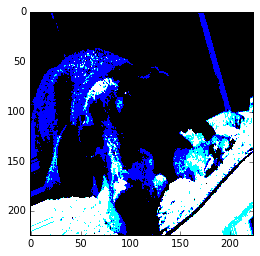

In [108]:
x,y = validation_generator.next()
test = x[63]
plt.imshow(test)

In [105]:
#Get generators
train_generator, validation_generator, test_generator = get_test_train_datagenerators(
    vgg16.preprocess_input, validation_split=0.1
)

Found 13137 images belonging to 120 classes.
Found 1394 images belonging to 120 classes.
Found 1817 images belonging to 120 classes.


In [109]:
#Train model
vgg16_model, vgg16_history = train_model(
    vgg16_model, train_generator, validation_generator
)

ValueError: None values not supported.